# Windowed prediction

This notebook is simply to reproduce how a single prediction is done.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score
from scipy.signal import medfilt
from scipy.ndimage.filters import gaussian_filter1d

sys.path.append("/Users/renero/Documents/SideProjects/trader/src")
sys.path.append("/Users/renero/Documents/SideProjects/trader/src/predictor")


from dictionary import Dictionary
from lstm import lstm
from predictor.ticks import Ticks
from predictor.sequences import sequences
from utils.utils import print_bin_predictions_match
from utils.plot_utils import plot_marks


%load_ext lab_black
%matplotlib inline

In [2]:
argv = [
    "",
    "-c",
    "../params/params.eurusd.yaml",
    "-f",
    "../data/EURUSD/EURUSD_2018_2020.csv",
    "--window",
    "28",
    "--epochs",
    "100",
    "train",
]
params = Dictionary(args=argv)


def read_ticks():
    global params

    ticks = Ticks(params, params.input_file).scale()
    ticks.append_indicator(["trend", "median_filter", "change"])
    ticks.append_indicator("gmf", monotonic_window=7, mf_window=3, sigma=5)
    ticks.append_indicator("gmf_mono", monotonic_window=7, mf_window=3, sigma=5)
    ticks.append_indicator("trend", column_name="gmf")
    return ticks


ticks = read_ticks()
XT, yT, Xt, yt = ticks.prepare_for_training(
    predict_column="close_trend", train_columns=["gmf", "gmf_mono", "gmf_trend"]
)
ticks.data.head()

2020-10-24 11:09:32 - INFO  - Dictionary:__init__             - Using configuration parameters from: ../params/params.eurusd.yaml


,open,high,low,close,close_trend,med_filter,change,returns,gmf,gmf_mono,gmf_trend
Datetime,,,,,,,,,,,
2018-01-01,1.2274,1.1598,1.2794,1.2442,1.0,1.2423,0.0000,0.000000,0.001247,0.0,1.0
2018-01-02,1.2292,1.2731,1.2922,1.3358,1.0,1.2442,0.0916,0.073622,0.001905,0.0,1.0
2018-01-03,1.3218,1.2430,1.2794,1.2423,0.0,1.2753,-0.0935,-0.069996,0.003268,0.0,1.0
2018-01-04,1.2292,1.2873,1.2849,1.3449,1.0,1.2918,0.1026,0.082589,0.005403,0.0,1.0
2018-01-05,1.3309,1.2767,1.3160,1.2753,0.0,1.2753,-0.0696,-0.051751,0.008347,0.0,1.0


---

## Compruebo si matchean la serie temporal y la serie numerica

Primero saco cual es la fecha del ultimo evento en training. Con el puedo construir una ventana de eventos con igual numero a la izqda y a la decha, que sea el numero de eventos de test.

In [3]:
last_date_in_training = ticks.last_date_in_training()
n_ticks = ticks.data.shape[0]
n_test = ticks.data.loc[ticks.data.index > last_date_in_training].shape[0]
D_size = int(np.ceil(2 * n_test))
print(f"{D_size} ticks, {n_test} in test and {D_size-n_test} in train (blue)")
D = ticks.data.iloc[-D_size:]

222 ticks, 111 in test and 111 in train (blue)


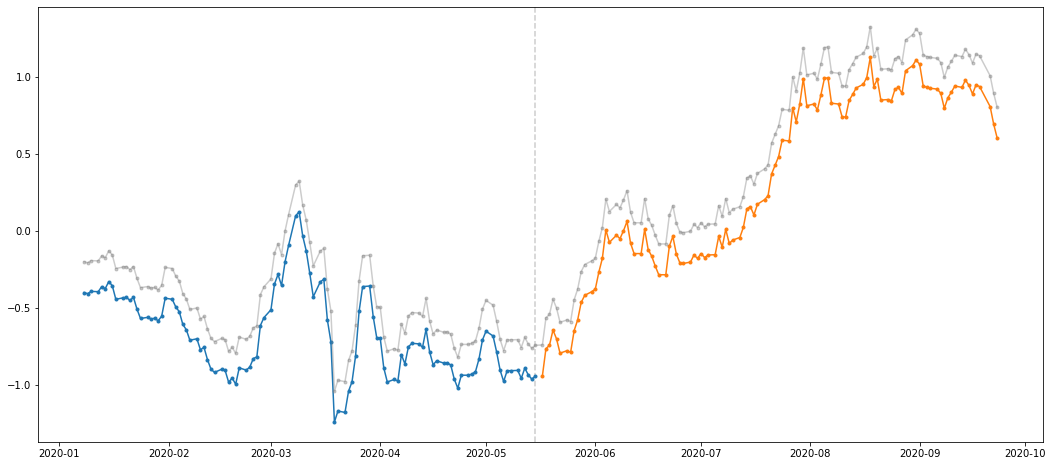

In [4]:
plt.figure(figsize=(18, 8))
plt.axvline(pd.Timestamp(last_date_in_training), alpha=0.2, color="k", linestyle="--")
plt.plot(D.loc[D.index <= last_date_in_training].close, marker=".")
plt.plot(D.loc[D.index > last_date_in_training].close, marker=".")
plt.plot(D.close + 0.2, color="grey", alpha=0.4, marker=".")
plt.show()

Ahora saco una ventana equivalente, pero utilizando la serie numérica, SIN fechas. Para ello utilizo el método privado `_last_index_in_training()` que me da el indice del último evento del conjunto de entrenamiento. Añadiendole `1`, lo que consigo es el primer valor en test (fit = first index in test) que me sirve para recrear la ventana de arriba, pero SIN fechas.

In [5]:
fit = (
    sequences._last_index_in_training(ticks.data, params.window_size, params.test_size)
    + 1
)
lit = fit - 1
n_test = n_ticks - fit
origin = n_ticks - (2 * n_test)
print(
    f"{n_ticks-origin} ticks, {n_test} in test and {n_ticks-origin-n_test} in training"
)

222 ticks, 111 in test and 111 in training


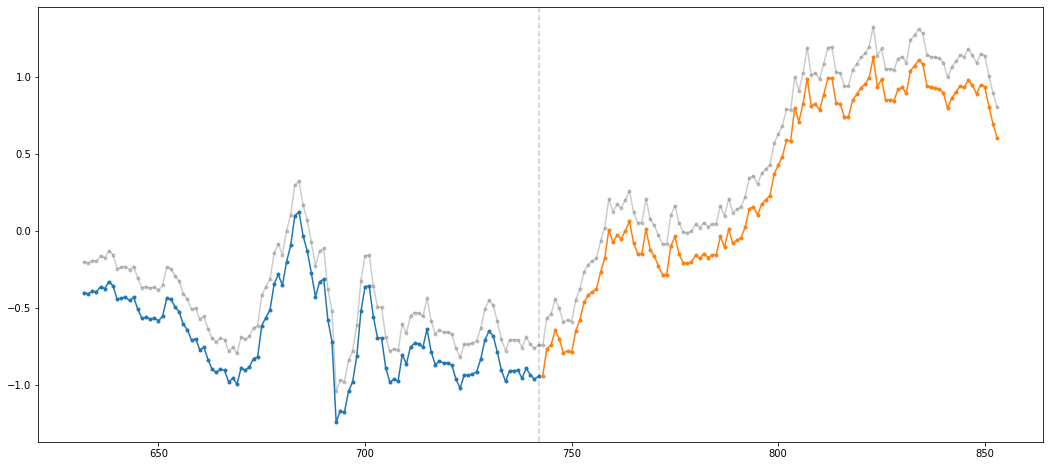

In [6]:
plt.figure(figsize=(18, 8))
plt.plot(
    range(origin, n_ticks),
    ticks.data.close.values[origin:] + 0.2,
    color="grey",
    alpha=0.4,
    marker=".",
)
plt.axvline(fit - 1, alpha=0.2, color="k", linestyle="--")
plt.plot(range(origin, lit + 1), ticks.data.close.values[origin : lit + 1], marker=".")
plt.plot(range(fit, n_ticks), ticks.data.close.values[fit:n_ticks], marker=".")
plt.show()

---

# Predicciones para el CLOSE_TREND

1) Leo la red de disco.

In [7]:
from typing import List

training_columns = ["gmf", "gmf_mono", "gmf_trend"]
scaler_file = "../staging/EURUSD/scaler_EURUSD_2018_2020.bin"
nn: List[lstm] = []
gmf_model = "LSTMb_gmf_trend(1l;28u;d=0.20;lr=0.01;[W14;E100;BS8])"
close_trend_models = [
    "LSTMb(1l;28u;d=0.20;lr=0.01;[W=28;E=150;BS=8])",
    "LSTMb(1l;42u;d=0.10;lr=0.01;[W=28;E=150;BS=16])",
    "LSTMb(1l;28u;d=0.20;lr=0.01;[W=14;E=150;BS=8])",
]
[nn.append(lstm(params).load(network)) for network in close_trend_models]
gmf_nn = lstm(params).load(gmf_model)

2) Leo los datos y me quedo solo con los datos de training.

In [8]:
raw = Ticks(params, csv_file=params.input_file)

n_windows = 0
last_training_date = raw.last_date_in_training()
test_df = raw.data[params.ohlc].loc[raw.data.index > last_training_date]

3) Creo un objeto Ticks, con los indicadores

In [9]:
test = Ticks(params, df=test_df).scale(scaler_file)
test.append_indicator(["trend", "median_filter", "change"])
test.append_indicator("gmf", monotonic_window=7, mf_window=3, sigma=5)
test.append_indicator("gmf_mono", monotonic_window=7, mf_window=3, sigma=5)
test.append_indicator("trend", column_name="gmf")

2020-10-24 11:09:34 - INFO  - Ticks:load_scaler               - Scaler loaded from ../staging/EURUSD/scaler_EURUSD_2018_2020.bin


4) Preparo todos los datos para hacer predicciones y las combino.

In [10]:
def combine_predictions(predictions, threshold=0.5):
    sum = 0
    for pred in predictions:
        if pred >= threshold:
            sum += 1
    return int(sum >= int(np.ceil(len(predictions) / 2.0)))

In [11]:
prepared_test = test.prepare_for_predict(training_columns)
yhat1 = []
for input_to_net in prepared_test:
    input_to_net = input_to_net.reshape(1, -1, len(training_columns))
    all_predictions = [network.model.predict(input_to_net) for network in nn]
    yhat1.append(combine_predictions(all_predictions))
    print(yhat1[-1], end="", flush=True)
print()

000001111111111111111111111111111111111111111111111111111111111110000000000000000000


In [12]:
y1 = test.data.iloc[-84:].close_trend.values.astype(int)
[print(yi, sep="", end="", flush=True) for yi in y1]
print()

accuracy_score(y1, yhat1)

000111000110101110101111101111111010110101110000111111010101101110000000111010010000


0.6785714285714286

# Repito el proceso para la red que predice el GMF_trend

In [13]:
training_columns = ["gmf", "gmf_mono"]
prepared_test = test.prepare_for_predict(training_columns)
yhat2 = []
for input_to_net in prepared_test:
    input_to_net = input_to_net.reshape(1, -1, len(training_columns))
    prediction = gmf_nn.model.predict(input_to_net)
    yhat2.append(combine_predictions(prediction))
    print(yhat2[-1], end="", flush=True)
print()

011111111111111100000000000011110000000000000000000000000000000000000000001111111111


In [15]:
y2 = test.data.iloc[-84:].gmf_trend.values.astype(int)
[print(yi, sep="", end="", flush=True) for yi in y2]
print()
accuracy_score(y2, yhat2)

001111111111111111111111111111111110000000000000000000000000000000000000000000000000


0.6904761904761905

---

Ahora debería entrenar también tres redes que predigan la señal gmf_trend, combinarlas y con esas dos intentar calcular la marca de BUY/SELL/HOLD.

In [14]:
df = pd.DataFrame({"c": test.data.iloc[-84:].close, "ct": y, "cp": yhat})

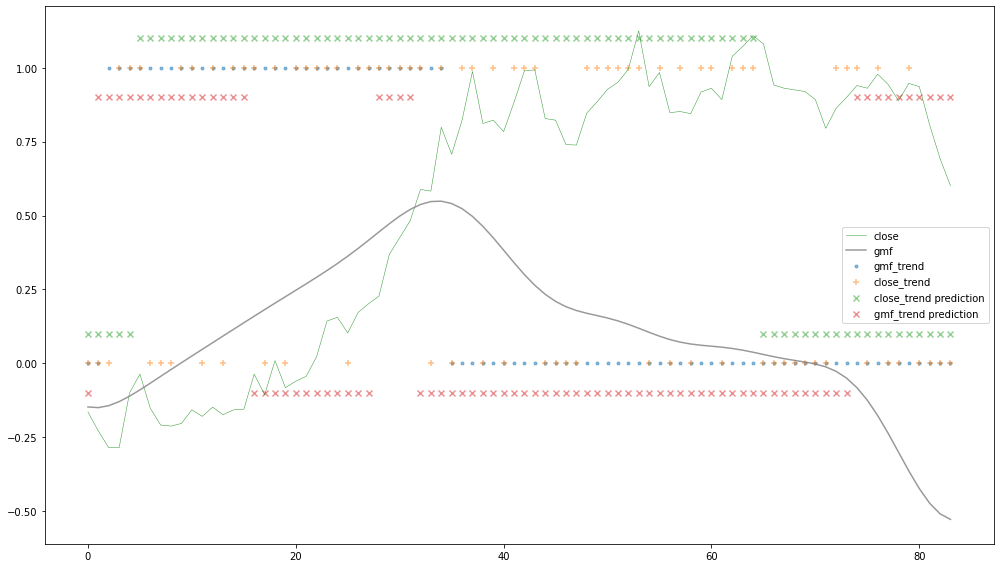

In [34]:
plt.figure(figsize=(14, 8))
plt.plot(
    test.data.iloc[-84:].close.values,
    color="green",
    alpha=0.8,
    label="close",
    linewidth=0.5,
)
plt.plot(test.data.iloc[-84:].gmf.values * 10.0, color="grey", alpha=0.8, label="gmf")
plt.scatter(
    range(len(y1)),
    test.data.iloc[-84:].gmf_trend,
    alpha=0.5,
    marker=".",
    label="gmf_trend",
)
plt.scatter(
    range(len(y1)),
    test.data.iloc[-84:].close_trend,
    alpha=0.5,
    marker="+",
    label="close_trend",
)
plt.scatter(
    range(len(y1)),
    np.array(yhat1) + 0.1,
    alpha=0.5,
    marker="x",
    label="close_trend prediction",
)
plt.scatter(
    range(len(y1)),
    np.array(yhat2) - 0.1,
    alpha=0.5,
    marker="x",
    label="gmf_trend prediction",
)
plt.legend()
plt.tight_layout()
plt.savefig("averaver.png")
plt.show()

In [ ]:
def f(x):
    return -np.cos(x) - np.sin(x) - (5 / 2) * np.cos(2 * x) + (1 / 2) * np.sin(2 * x)


X = np.arange(15.0)
s = pd.DataFrame({"x1": X, "x2": [f(x) for x in X]})

plt.plot(s.x2)
plt.title("stock (simulated)")
plt.show()

Plotting the MF with the data available ONLY up to a certain day (starting at 8th day, up to 13th), the result is that MF with partial data doesn't match the MF computed over the entire series of data, but deviates not too much. In a real life scenario, this shorter window can be extended with the forecast value of the signal for the next day to get a more accurate approximation of the MF signal.

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(20, 8)
w_size = 9
for row in range(2):
    for column in range(3):
        ax[row, column].plot(s.x2, linewidth=0.8, marker=".", label="stock")
        ax[row, column].plot(medfilt(s.x2, kernel_size=3), alpha=0.5, label="mf")
        ax[row, column].plot(
            medfilt(s.x2[:w_size], kernel_size=3), linestyle="dashed", label="today"
        )
        ax[row, column].axvline(w_size - 1, linewidth=0.5, color="grey")
        ax[row, column].legend()
        w_size += 1

fig.suptitle("Medfilt up-to-day compared with complete series medfilt")
plt.tight_layout()
plt.show()

Gaussian filtered signal computed over the stretched up-to-day window suffers the same deviation, as it is computed over the shorter MF signal. By using forecast we could get a more accurate version of the Gaussian1d filter, given that the forecast is correct.

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(20, 8)
w_size = 9
for row in range(2):
    for column in range(3):
        ax[row, column].plot(s.x2, linewidth=0.8, marker=".", label="stock")
        ax[row, column].plot(
            medfilt(s.x2, kernel_size=3), alpha=0.5, label="mf",
        )
        ax[row, column].plot(
            gaussian_filter1d(medfilt(s.x2, kernel_size=3), sigma=2),
            alpha=0.5,
            label="gaus.",
        )
        ax[row, column].plot(
            gaussian_filter1d(medfilt(s.x2[:w_size], kernel_size=3), sigma=2),
            linestyle="dashed",
            label="today",
        )
        ax[row, column].axvline(w_size - 1, linewidth=0.5, color="grey")
        w_size += 1
        ax[row, column].legend()

fig.suptitle("Gaussian up-to-day compared with complete series gaussian")
plt.tight_layout()
plt.show()